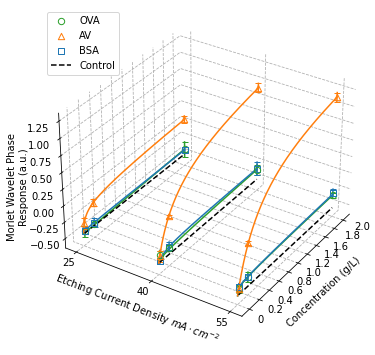

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from enum import Enum

# input parameters
Concentrations = [0.02, 0.2, 2] #g/L
markerSize = 40
NumIncrementsTrendline = 200
ConcentrationIncrements = np.linspace(0, 2, num=NumIncrementsTrendline) #g/L
Colours = ['tab:green', 'tab:blue', 'tab:orange']
MarkerShapes = ['o', 's', '^']

# enum classes
# target proteins: chicken ovalbumin (OVA), bovine serum albumin (BSA), and avidin (AV)
class Proteins(Enum):
    OVA = 0
    BSA = 1
    AV = 2

# pore sizes, etched using current densities of 55mA*cm^-2 (large pores),
# 40mA*cm^-2 (medium pores), and 25mA*cm^-2 (small pores)
class PoreSizes(Enum):
    LARGE55MA = 0
    MEDIUM40MA = 1
    SMALL25MA = 2

# filepath locations of response matrix data and optimal best fit parameters for adsorption isotherm trendline
ResponseMatrixFilePath = "../TrainingData/SensorArrayProteinResponseMatrixPairwiseAveraging.csv"
AdsorptionIsothermParametersFilePath = "../TrainingData/SensorArrayProteinResponseMatrixRedlichPetersonFitParameters.csv"

# load dataset into pandas DataFrame
df_data = pd.read_csv(ResponseMatrixFilePath, sep=',',header=0)
df_coeff = pd.read_csv(AdsorptionIsothermParametersFilePath, sep=',', header=None)

# convert dataframe into np.array
AdsorptionIsothermParameters = df_coeff.values

# find mean and standard deviation of responses, for each sensor element in the array indivadiaully,
# across any given experimental condition (eg. protein and concentration)

# label columns for each experimental condition, both mean and standard deviation
LabelledMeanStdData = np.expand_dims(np.concatenate((df_data.columns.values[:-1],df_data.columns.values[1:])),1)
LabelledMeanStdData[1:7] = "Mean" + LabelledMeanStdData[1:7]
LabelledMeanStdData[7:13] = "Std" + LabelledMeanStdData[7:13]

# for each unique experimental condition, take the mean and standard deviation for each sensor element in array,
# append to LabelledMeanStdData array
for experimentalcondition in df_data.ExperimentalConditions.unique():
    data = (df_data.loc[df_data['ExperimentalConditions'] == experimentalcondition]).values[:,1:].astype(float)
    MeanStdRow = np.expand_dims(np.concatenate(([experimentalcondition]
                                                , np.mean(data, axis=0)[:-1]
                                                , np.std(data, axis=0)[:-1]
                                                , [np.mean(data, axis=0)[-1]])),1)
    LabelledMeanStdData = np.concatenate((LabelledMeanStdData,MeanStdRow),axis=1)

# convert numerical data to floats and remove labels
LabelledMeanStdData[1:,1:] = LabelledMeanStdData[1:,1:].astype(float)
MeanStdData = LabelledMeanStdData[1:,1:].T

# set up 3d plot
fig = plt.figure()
plt.rcParams["grid.linestyle"]="dashed"
ax = fig.add_subplot(111, projection='3d')

for poresize in PoreSizes:
    
    # arrays for plotting data corresponding to a single pore size
    PoreSizeArray = [poresize.value]*len(Concentrations)
    PoreSizeTrendlineArray = np.ones(NumIncrementsTrendline)*poresize.value
    
    # loop over the three proteins
    for protein, markershape, colour in zip(Proteins,MarkerShapes,Colours):
        
        # load 3 rows of mean sensor array responses corresponding to each protein in turn,
        # pH4 experimental conditions, and each pore size in turn 
        MeanResponse = MeanStdData[protein.value*3:protein.value*3+3,poresize.value*2+1]

        ax.scatter(Concentrations,[poresize.value]*3,MeanResponse, facecolor=(0,0,0,0), edgecolor=colour, label=protein.name, depthshade=False, marker=markershape, s=markerSize)

        # load 3 rows of standard deviations of sensor array responses corresponding to each protein in turn,
        # pH4 experimental conditions, and each pore size in turn
        StandardDeviationResponse = MeanStdData[protein.value*3:protein.value*3+3,7+poresize.value*2]

        # scatter plot of 6 dimensional sensor response with standard deviation error bars
        for i in np.arange(0, len(MeanResponse)):
            ax.plot([Concentrations[i], Concentrations[i]], [poresize.value]*2
                    , [MeanResponse[i]+StandardDeviationResponse[i], MeanResponse[i]-StandardDeviationResponse[i]]
                    , marker="_", color=colour)

        # load best fit coefficients, calculate, and plot adsorption isotherm
        coeffs = AdsorptionIsothermParameters[:,protein.value+6*poresize.value+3]
        AdsorptionIsoethermTrendline = coeffs[0] + coeffs[1]*ConcentrationIncrements/(1+coeffs[2]*(ConcentrationIncrements**coeffs[3]))
        ax.plot(ConcentrationIncrements, PoreSizeTrendlineArray, AdsorptionIsoethermTrendline, color=colour)

    # plot control for each pore size as black dashed line
    MeanResponse = [MeanStdData[9,poresize.value*2+1], MeanStdData[9,poresize.value*2+1], MeanStdData[9,poresize.value*2+1]]
    ax.plot(Concentrations,PoreSizeArray,MeanResponse, '--', color='k', label='Control')

# add legend
handles,labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1],  handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]
ax.legend(handles,labels,loc='upper left')

# set 3d viewing angle
ax.view_init(elev=32, azim=-147)

# set tick labels
ax.axes.set_yticks([0, 1, 2])
ax.axes.set_yticklabels(['55', '40', '25'], verticalalignment= 'bottom')
ax.axes.set_xticklabels([])
ax.text(2.08, -0.25, -0.8, '2.0', fontsize = 'medium')
ax.text(0.2, -0.25, -0.8, '0.2', fontsize = 'medium')
ax.text(0.4, -0.25, -0.8, '0.4', fontsize = 'medium')
ax.text(0.6, -0.25, -0.8, '0.6', fontsize = 'medium')
ax.text(0.8, -0.25, -0.8, '0.8', fontsize = 'medium')
ax.text(1, -0.25, -0.8, '1.0', fontsize = 'medium')
ax.text(1.2, -0.25, -0.8, '1.2', fontsize = 'medium')
ax.text(1.4, -0.25, -0.8, '1.4', fontsize = 'medium')
ax.text(1.6, -0.25, -0.8, '1.6', fontsize = 'medium')
ax.text(1.86, -0.25, -0.8, '1.8', fontsize = 'medium')
ax.text(0, -0.25, -0.8, '0', fontsize = 'medium')
ax.axes.set_xticks(([0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]))

# set axis labels
ax.set_xlabel('Concentration (g/L)')
ax.set_ylabel('Etching Current Density '+ r'$mA \cdot cm^{-2}$', labelpad=-1)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Morlet Wavelet Phase\nResponse (a.u.)', rotation=90)
plt.tick_params(right = False)

fig.set_figwidth(6)
fig.set_figheight(6)

# set background colour to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.savefig("../Figures/SensorArrayProteinResponsepH10.tif", dpi=400, bbox_inches='tight')